# Audio Data Preparation and Augmentation

## Overview

This notebook will be a good start on preparing and analyzing audio data. 

## Setup 

Install required packages, and restart runtime

In [1]:
!pip install tensorflow-io

     |████████████████████████████████| 24.1 MB 711 kB/s eta 0:00:01


## Usage

### Read an Audio File

In TensorFlow IO, class [tfio.audio.AudioIOTensor](https://www.tensorflow.org/io/api_docs/python/tfio/audio/AudioIOTensor) allows you to read an audio file into a lazy-loaded IOTensor:

In [2]:
import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

print(audio)

2022-04-12 08:27:20.338397: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-04-12 08:27:20.477649: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 08:27:23.480286: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "INTERNAL: Couldn't parse JSON response from OAuth server.".


<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>


In [9]:
audio.shape

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([28979,     1])>

In [14]:
print(audio[:])
print(len(audio[:]))
print(audio[0])

tf.Tensor(
[[-184]
 [-181]
 [-156]
 ...
 [  56]
 [  81]
 [  83]], shape=(28979, 1), dtype=int16)
28979
tf.Tensor([-184], shape=(1,), dtype=int16)


# Takeaways

* audio is an AudioIOTensor with a shape of [28979, 1]

In the above example, the Flac file `brooklyn.flac` is from a publicly accessible audio clip in [google cloud](https://cloud.google.com/speech-to-text/docs/quickstart-gcloud).

The GCS address `gs://cloud-samples-tests/speech/brooklyn.flac` are used directly because GCS is a supported file system in TensorFlow. In addition to `Flac` format, `WAV`, `Ogg`, `MP3`, and `MP4A` are also supported by `AudioIOTensor` with automatic file format detection.

`AudioIOTensor` is lazy-loaded so only shape, dtype, and sample rate are shown initially. The shape of the `AudioIOTensor` is represented as `[samples, channels]`, which means the audio clip you loaded is mono channel with `28979` samples in `int16`.

The content of the audio clip will only be read as needed, either by converting `AudioIOTensor` to `Tensor` through `to_tensor()`, or though slicing. Slicing is especially useful when only a small portion of a large audio clip is needed:

# Takeaways

* GCS(Google Cloud Storage)
* AudioIOTensor is represented as [samples, channgels]
* AudioIOTensor data must be converted to a Tensor using to_tensor() or can be processed using slicing. 
* Slicing is useful when small portions of large audio clips are needed.

In [3]:
audio_slice = audio[100:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([16 39 66 ... 56 81 83], shape=(28879,), dtype=int16)


### The audio can be played through:

In [4]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate = audio.rate.numpy())

It is more convenient to convert tensors into float numbers and express the audio clip as a graph:

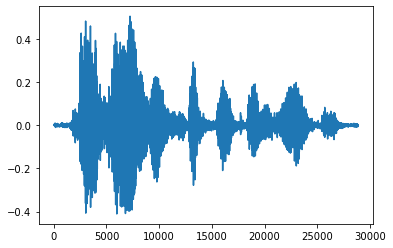

In [5]:
import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())